## Overview
Explore data in order to find how to help wine company.

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm
RANDOM_STATE = 42
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_auc_score, r2_score, mean_squared_error

In [2]:
df = pd.read_csv('winequalityN.csv')
df.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


## Business Problem
Want more higher quality. What makes a wine high quality? Change to classification, predict and use the feature importance to pull information about what makes a wine high quality. "Using this info we now know what makes a wine good, now we can do reseach on how to make those things happen" ie: how to have higher pH if thats what makes it good, or how to have more residual sugars, or less. Using this info we can produce more higher quality wine and make more money off of it. 


In [4]:
columns = {}
# I dont like spaces in my column names so I replaced them with underscores
for column in df.columns:
    columns[column] = column.replace(" ", "_")
df.rename(columns=columns, inplace=True)
df['quality'].replace(to_replace=[3,4,5,6,7,8,9], value=[0,0,0,0,1,1,1], inplace=True)
df = df.join(pd.get_dummies(df.type))
df.drop('type', axis=1, inplace=True)
df.dropna(inplace=True)

In [14]:
def performance(y_true, y_predict):
    """ 
    Calculates and returns the two performance scores between 
    true and predicted values - first R-Squared, then accuracy
    From Regression Trees and Model Optimization - Lab
    """

    f1 = f1_score(y_true, y_predict)
    accuracy = accuracy_score(y_true, y_predict)
    roc_auc = roc_auc_score(y_true, y_predict)

    return [f1, accuracy, roc_auc]
def get_score(model, x_train, x_test, y_train, y_test):
    """
    Returns score from any given model and train test split data
    """
    
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    score = performance(y_test, y_pred)
    return score
def plot_score(parameter, parameter_name, mse_results, f1_results, roc_auc_results):
    """
    Plots score given a parameter, parameter_name and their results.
    Original code from Hyperparameter tuning - Lab
    """
    plt.figure(figsize=(12, 6))
    plt.plot(parameter, f1_results, 'b', label='f1')
    plt.xlabel(parameter_name)
    plt.ylabel('f1-score')
    plt.legend()
    plt.show()
    plt.figure(figsize=(12, 6))
    plt.plot(parameter, mse_results, 'r', label='accuracy')
    plt.xlabel(parameter_name)
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()
    plt.figure(figsize=(12, 6))
    plt.plot(parameter, roc_auc_results, 'g', label='ROC AUC')
    plt.xlabel(parameter_name)
    plt.ylabel('ROC AUC')
    plt.legend()
    plt.show()
    
def tuner(classifier_name:str, parameter, parameter_name:str, x_train, x_test, y_train, y_test):
    accuracy_results = []
    f1_results = []
    roc_auc_results = []
    for para in parameter:
        classifier = eval('{}(random_state=RANDOM_STATE, {}=para, class_weight={})'.format(classifier_name, parameter_name, {0:1, 1:5}))
        score = get_score(classifier, x_train, x_test, y_train, y_test)
        f1_results.append(score[0])
        accuracy_results.append(score[1])
        roc_auc_results.append(score[2])
    plot_score(parameter, parameter_name, accuracy_results, f1_results, roc_auc_results)

In [6]:
results = {}
for column in df.columns:
    results[column] = df[column].value_counts()

In [7]:
parameters = {
    'min_samples_split' : list(np.arange(2, 100)),
    'max_depth' : list(np.linspace(1,30,30)),
    'min_samples_leaf' : list(np.arange(2,40)),
    'min_weight_fraction_leaf' : list(np.linspace(0,.5,30)),
    'max_features' : list(np.linspace(.01,1,30)),
    'max_leaf_nodes' : list(np.arange(2, 100))
}

In [8]:
target = df[['quality']]
df.drop('quality', axis=1, inplace=True)
x_train, x_test, y_train, y_test = train_test_split(df, target, test_size=.2, random_state=RANDOM_STATE)

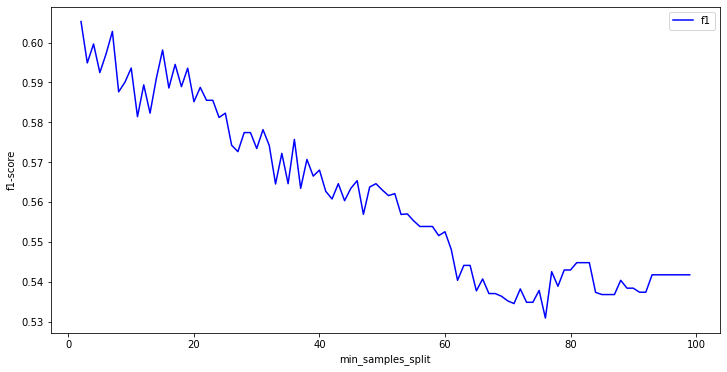

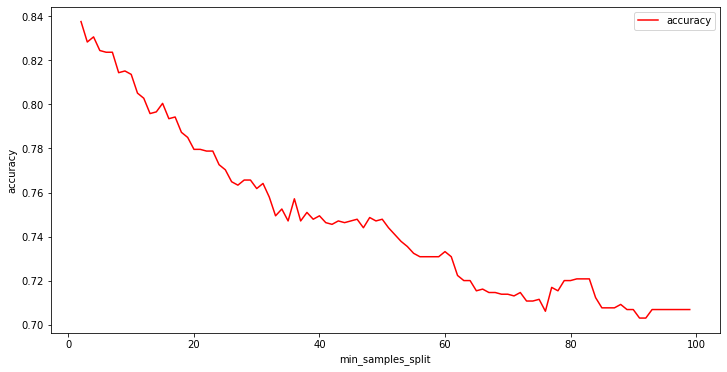

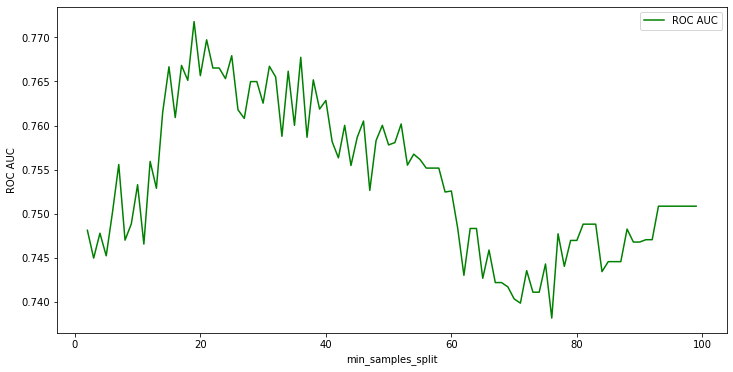

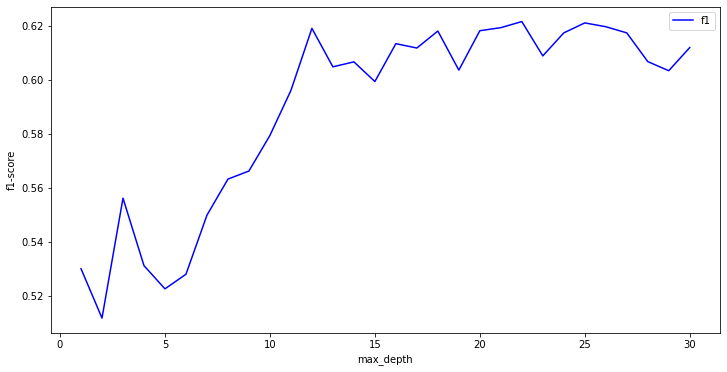

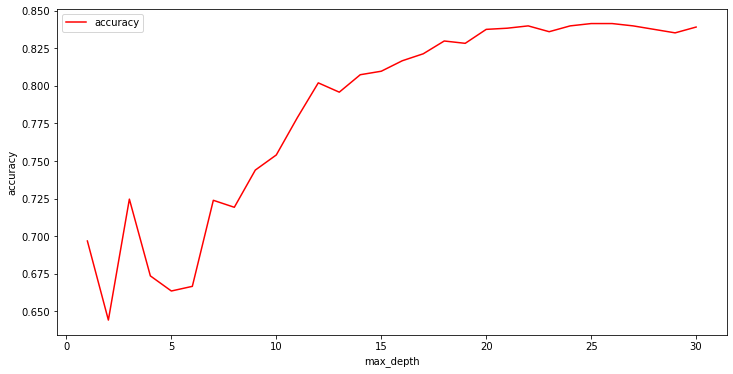

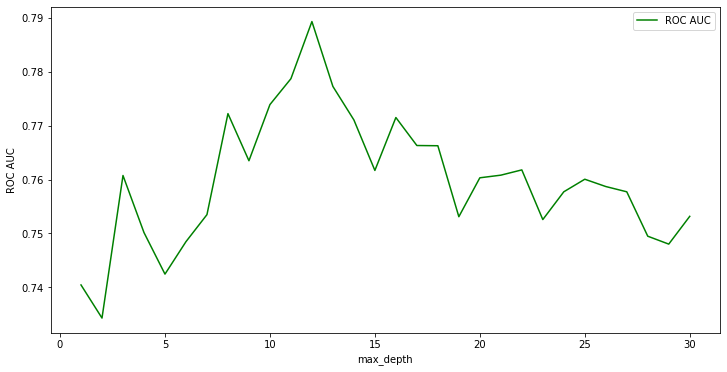

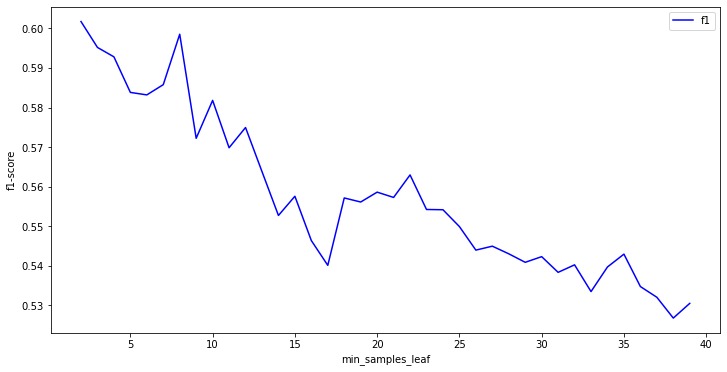

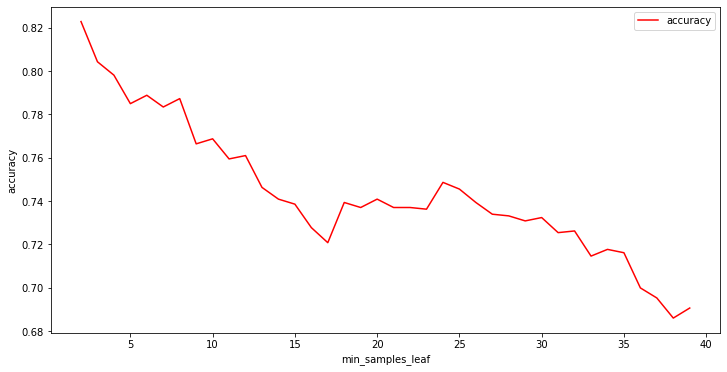

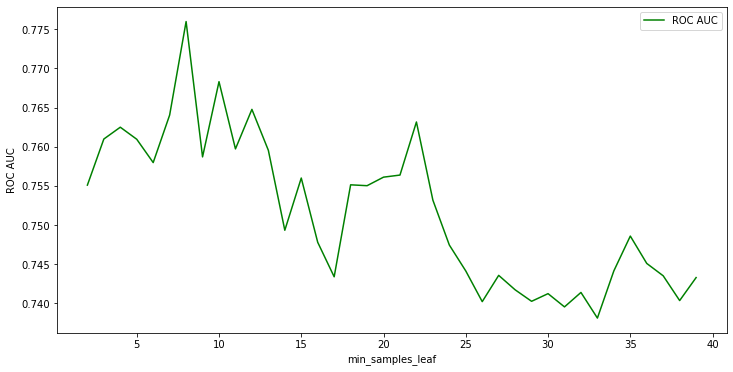

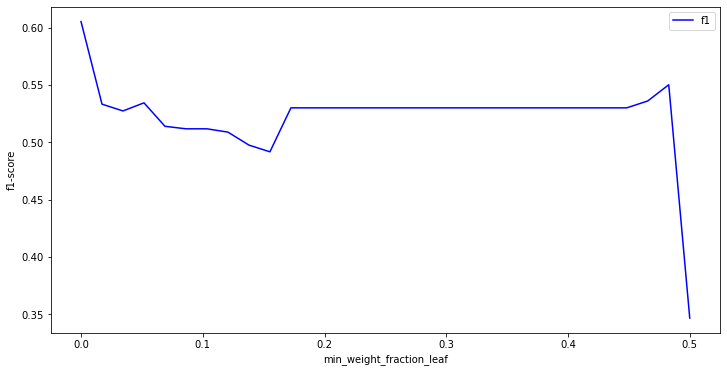

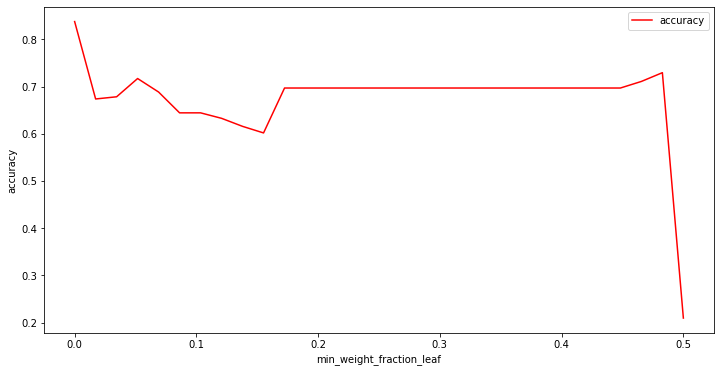

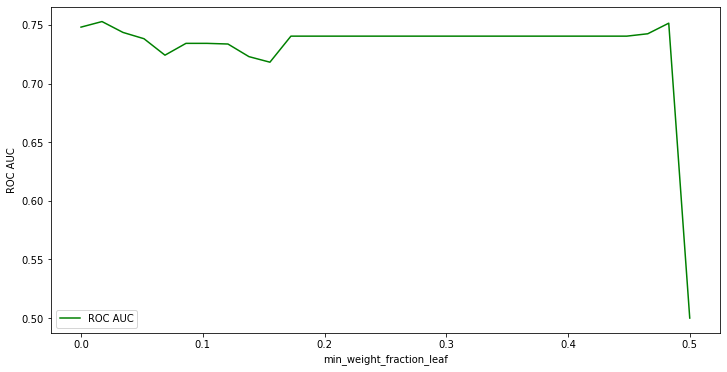

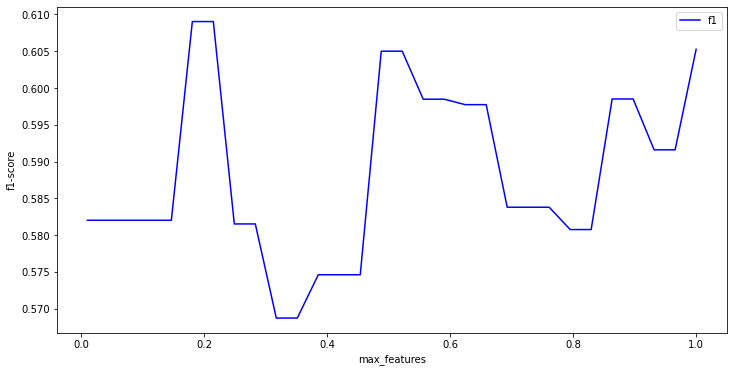

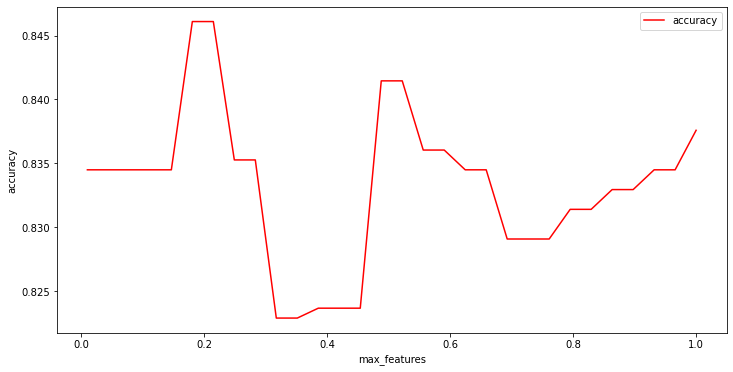

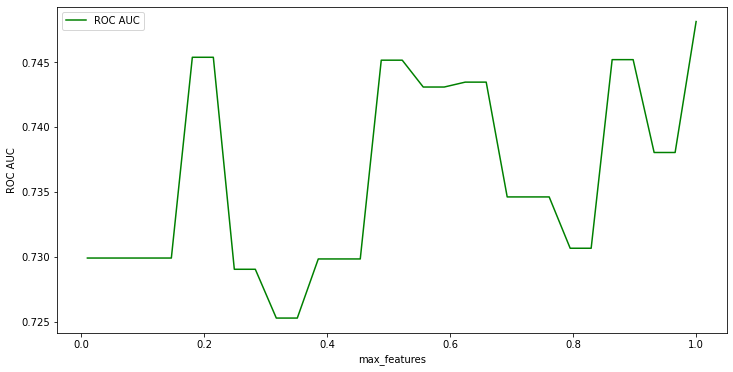

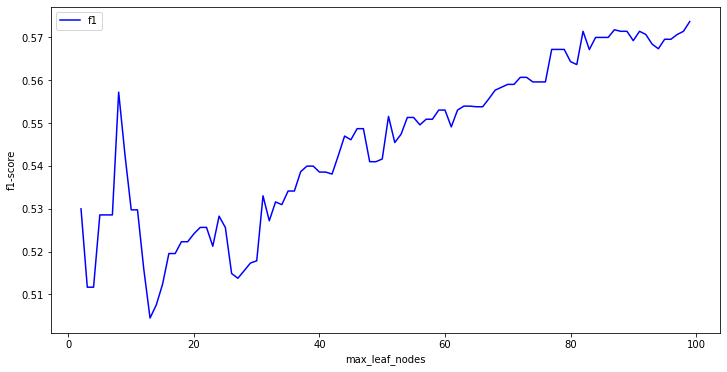

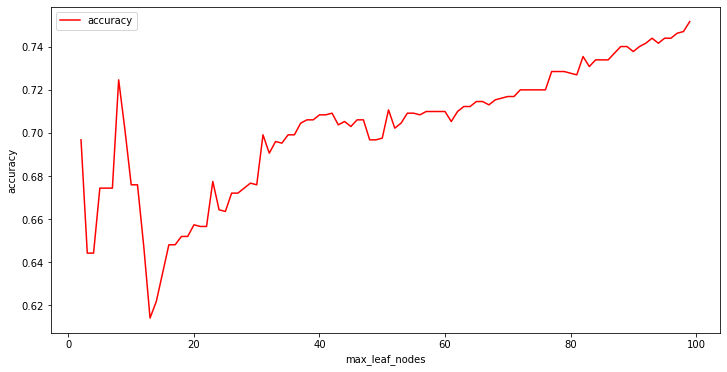

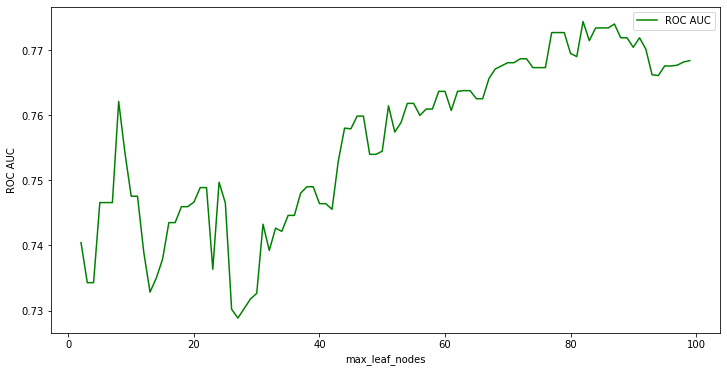

In [15]:
for parameter in parameters:
    tuner("DecisionTreeClassifier", parameters[parameter], parameter, x_train, x_test, y_train, y_test)